# **GUNITA - Programming Assignment 2**
<h2>Logistic Regression</h2>

## Loading the Dataset

In [1]:
!pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo

breast_cancer = fetch_ucirepo(id=17)

# We only used the mean values for each feature.
x = breast_cancer.data.features
x = x.filter(regex='1$')
y = breast_cancer.data.targets

Loading the necessary modules.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score


## Exploratory Data Analysis

In [4]:
print(str(breast_cancer.metadata.additional_info.variable_info))

1) ID number
2) Diagnosis (M = malignant, B = benign)
3-32)

Ten real-valued features are computed for each cell nucleus:

	a) radius (mean of distances from center to points on the perimeter)
	b) texture (standard deviation of gray-scale values)
	c) perimeter
	d) area
	e) smoothness (local variation in radius lengths)
	f) compactness (perimeter^2 / area - 1.0)
	g) concavity (severity of concave portions of the contour)
	h) concave points (number of concave portions of the contour)
	i) symmetry 
	j) fractal dimension ("coastline approximation" - 1)


In [5]:
x.head()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


In [6]:
y.head()

,Diagnosis
0,M
1,M
2,M
3,M
4,M


In [7]:
# Replacing the labels from M and B to 1 and 0, respectively
y.loc[:, 'Diagnosis'] = y['Diagnosis'].replace({'M': 1, 'B': 0})
y['Diagnosis'] = y['Diagnosis'].astype(int)
y.head()

C:\Users\Gillian\AppData\Local\Temp\ipykernel_8716\364585148.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y.loc[:, 'Diagnosis'] = y['Diagnosis'].replace({'M': 1, 'B': 0})
C:\Users\Gillian\AppData\Local\Temp\ipykernel_8716\364585148.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Diagnosis'] = y['Diagnosis'].astype(int)


,Diagnosis
0,1
1,1
2,1
3,1
4,1


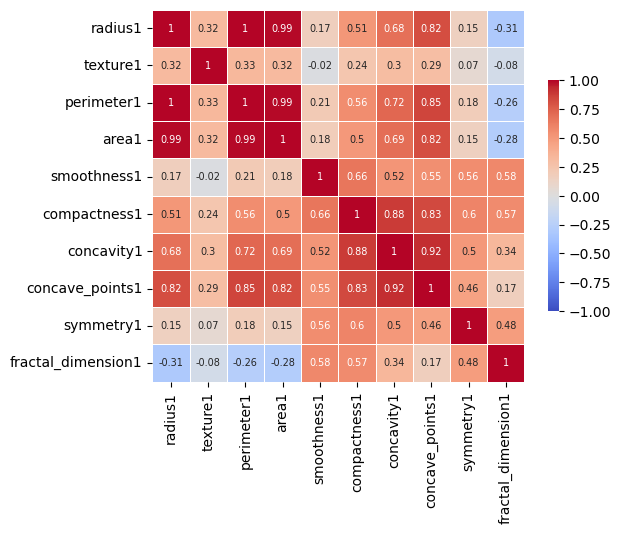

In [8]:
# Generate and visualize the correlation matrix
def heatmap(x):
  corr = x.corr().round(2)
  f, ax = plt.subplots(figsize=(6, 6))
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws={"fontsize":7})
  plt.show()

heatmap(x)

It appears there is a strong linear relationship between perimeter, area, and radius, which makes sense since the radius determines both the perimeter and area. To prevent multicollinearity, we should remove perimeter and area, as keeping them could lead to unreliable coefficient estimates. The same reasoning applies to concavity, compactness, and concave points, so it would be logical to remove concavity and concave points to avoid multicollinearity.

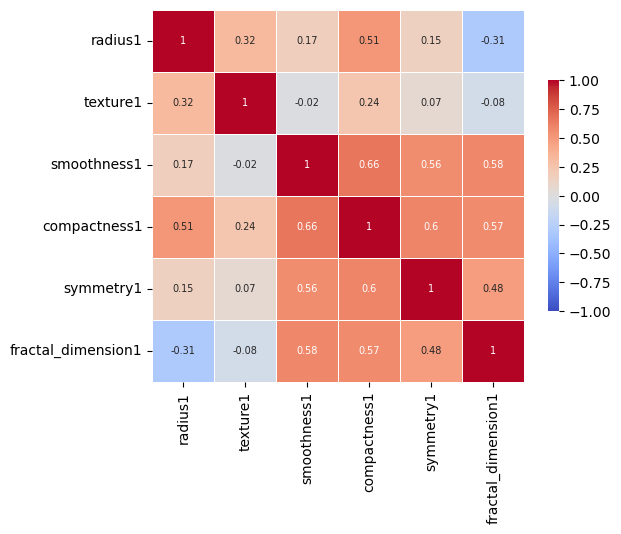

In [9]:
# Visualize the correlation matrix for the chosen features
x = x[['radius1', 'texture1', 'smoothness1', 'compactness1', 'symmetry1', 'fractal_dimension1']]
heatmap(x)

## Model Training

### Step 1. Splitting the data

In [10]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=7)

### Step 2. Logistic Regression

In [11]:
# Create a standardScaler and logistic regression pipeline
model = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression())])

# Fit the pipeline to the training set
model.fit(x_train, y_train)

# Use the model to predict the values for the test set
y_pred = model.predict(x_test)

d:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Step 3. Model Evaluation

In [12]:
# Determine the training and testing accuracy
print(f"Training Accuracy = {round(model.score(x_train, y_train), 2)}")
print(f"Testing Accuracy = {round(model.score(x_test, y_test), 2)}")

# Show the coefficient values
for key, coef in zip(x.keys(), model.named_steps.model.coef_[0]):
  print(f"{key}: {round(coef, 2)}")

print(f"Intercept: ", model.named_steps.model.intercept_)

Training Accuracy = 0.94
Testing Accuracy = 0.92
radius1: 3.28
texture1: 1.2
smoothness1: 1.05
compactness1: 0.99
symmetry1: 0.5
fractal_dimension1: -0.49
Intercept:  [-0.96137444]


The model achieves a training accuracy of 94% and a testing accuracy of 92%. The most significant feature is the mean radius, with a coefficient of 3.28. Mean texture, smoothness, and compactness contribute roughly equally to the predictions, while both symmetry and fractal dimensions have relatively low coefficients.

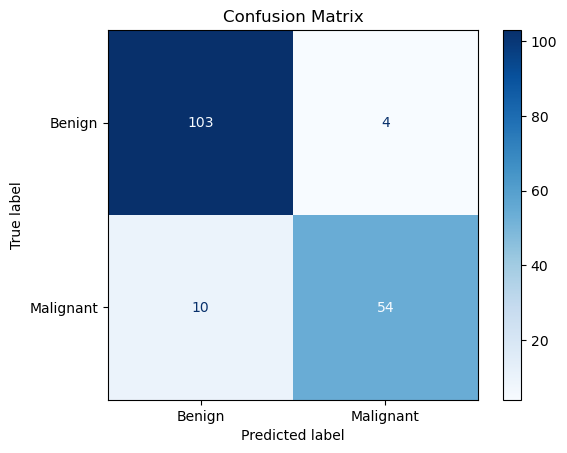

In [14]:
cfm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=["Benign", "Malignant"])

cm_display.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.show()

In calculating the metrics, we arbitrarily set the benign class as False and the malignant class as True. This choice can be justified by framing the label as an indicator of whether the lesion is cancerous (malignant) or not (benign). The malignant label (True) signifies the presence of cancer, while the benign label (False) signifies its absence.

In [15]:
# Extracting the predictions
TN = cfm[0][0]
FN = cfm[1][0]
TP = cfm[1][1]
FP = cfm[0][1]

# Calculating the model evaluation metrics
precision = TP / (TP + FP)
recall = TP / (TP + FN)
far = FP / (FP + TN)
f1 = 1 / ((1 / precision) + (1 / recall))

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"False Alarm Rate: {far}")
print(f"F1-score: {f1}")

Precision: 0.9310344827586207
Recall: 0.84375
False Alarm Rate: 0.037383177570093455
F1-score: 0.44262295081967207


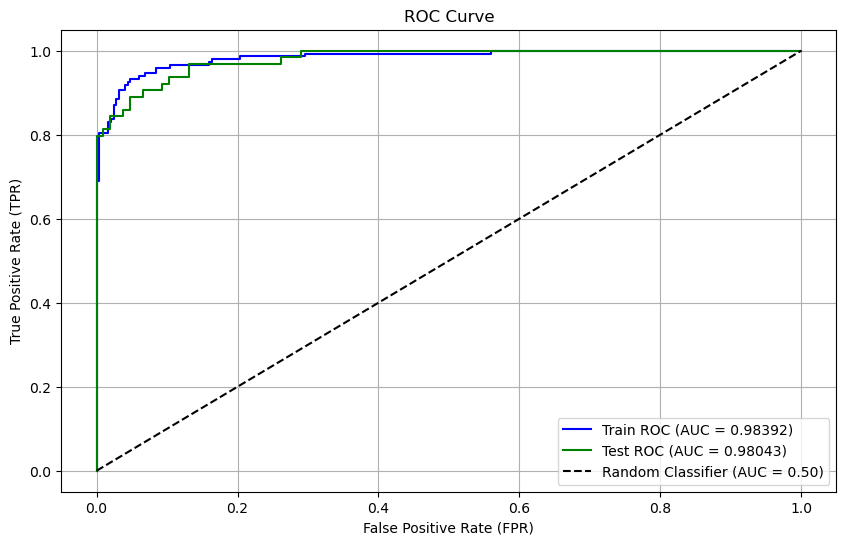

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Use predict_proba to get probabilities
y_train_probs = model.predict_proba(x_train)[:, 1]
y_test_probs = model.predict_proba(x_test)[:, 1]

# Compute ROC curve and AUC for training
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
auc_train = roc_auc_score(y_train, y_train_probs)

# Compute ROC curve and AUC for testing
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)
auc_test = roc_auc_score(y_test, y_test_probs)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.5f})", color='blue')
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {auc_test:.5f})", color='green')
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Add labels and legend
plt.title("ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Questions

### Guide Question 1
**What steps are required to remove the "Sample code number" column?**

The provided dataset does not include a Sample code number column. However, it appears that the Sample code number serves as an ID column. You can remove it from the dataset by using the .drop() method from pandas.DataFrame.

### Guide Question 2
**How can the "Class" values be converted into binary (0 and 1) form in Python?**

There are several ways to approach this encoding. According to the documentation, the corresponding values for benign and malignant are 2 and 4, respectively. A quick way to encode these values is by reassigned the Diagnosis column as follows: df['Diagnosis'] = df['Diagnosis'] / 2 - 1. This will transform the values 2 and 4 into 0 (benign) and 1 (malignant), respectively.

### Guide Question 3
**What is the importance of splitting the dataset into training and testing sets?**

By splitting the dataset into training and testing sets, we create two isolated datasets that are used for training and evaluating machine learning models. In this case, the training set was used to fit the data into a logistic regression model.

### Guide Question 4
**Why is it necessary to use the stratify parameter in the train_test_split function?**

The `stratify` parameter ensures that the dataset is split evenly, preserving the proportions of different classes in both the training and testing sets. This is particularly useful when dealing with imbalanced classes, like benign (B) and malignant (M) in this case. By using `stratify`, the ratios of these classes in the training and testing sets will be maintained, ensuring that both sets accurately represent the overall distribution of the classes.

### Guide Question 5
**What is logistic regression, and why is it suitable for this dataset?**

Logistic regression is a machine learning model commonly used for classification tasks, particularly when the target variable is categorical with two classes. This makes it suitable for the dataset at hand, where the ground truth labels represent two categories: benign and malignant. In this case, logistic regression is applied to perform binary classification, predicting whether a given sample is benign or malignant based on the features.

### Guide Question 6
**How can the training and testing accuracy of the logistic regression model be calculated?**

The accuracy of a logistic regression model can be determined using a confusion matrix, which provides valuable insights into the model's performance. From the confusion matrix, several metrics can be derived, including precision, recall, accuracy, and F1 score. Additionally, the confusion matrix is essential for visualizing the Receiver Operating Characteristic (ROC) curve, which plots the true positive rate (TPR) against the false positive rate (FPR). The ROC curve helps evaluate the model's performance at various thresholds, with a higher area under the curve (AUC) indicating a better model across all thresholds.

### Guide Question 7
**Which features in the dataset are most influential in determining the tumor status, and how can their importance be assessed?**

The radius is the most significant feature in determining tumor status, followed by texture, smoothness, compactness, symmetry, and finally, fractal dimension. The coefficient values for these features are provided below.

radius1: 3.28<br>
texture1: 1.2<br>
smoothness1: 1.05<br>
compactness1: 0.99<br>
symmetry1: 0.5<br>
fractal_dimension1: -0.49<br>

### Guide Question 8
**How is a confusion matrix generated, and what does it represent?**

The confusion matrix can be visualized using the `roc_curve()` function from `sklearn.metrics`. This function plots the actual values against the predicted values, highlighting false positive errors, false negative errors, true positive results, and true negative results. The confusion matrix acts as a summary statistic for a classification task, providing a comprehensive overview of the model's performance.

### Guide Question 9
**How are precision, recall, F1-score, and false alarm rate calculated from the confusion matrix?**

Given a confusion matrix, precision, recall, F1-score, and false alarm rate can be calculated as follows:

$$ precision = \frac{TP}{TP+FP} $$
$$ recall = \frac{TP}{TP+FN} $$
$$ F1 = \frac{1}{\frac{1}{TP}+\frac{1}{FP}} $$
$$ FAR = \frac{FP}{FP+TN} $$


### Guide Question 10
**Why are these metrics important for evaluating the performance of a classifier?**

These metrics evaluate the performance of a classification model, with their importance varying based on the use case. Precision is valuable for tasks like spam filtering, recall is critical for applications such as medical diagnosis, and the F1-score is useful for balancing the benefits of both precision and recall. By adjusting the thresholds, a machine learning engineer can prioritize the metrics that are most relevant to the specific use case.

### Guide Question 11
**What is an ROC curve, and how is it plotted for a logistic regression model?**

The ROC (Receiver Operating Characteristic) curve is created by comparing the true positive rate and false positive rate, helping to evaluate the model's performance across all thresholds. A steeper ROC curve indicates a better-performing model, as it shows a higher true positive rate and a lower false positive rate.

### Guide Question 12
**How is the AUC (Area Under the Curve) calculated, and what does it signify about the model's performance?**

The AUC (Area Under the Curve) refers to the area beneath the ROC curve. A higher AUC value indicates a better ROC curve, signifying better overall performance of the model. The closer the AUC is to 1, the more effective the model is at distinguishing between the classes.

### Guide Question 13
**How do the training and testing ROC curves compare, and what insights can be derived from this comparison?**

The training ROC curve is better than the test ROC curve, indicating that the model performs better across all thresholds on the training set compared to the test set. This is a common observation in machine learning evaluations. It suggests that the model may be overfitting to the training data, but since the test ROC curve doesn't deviate too much from the training ROC curve, it likely indicates a balanced model. If there were a significant difference between the two, it could imply underfitting or overfitting, where the model doesn't generalize well to unseen data.

### Guide Question 14
**What challenges did you encounter during the preprocessing or model training phases, and how did you address them?**

The main challenge we encountered was preprocessing the data, as the provided dataset differed from what was documented in the programming assignment. The features contained three variations of the same feature, which we identified after some research as the mean, standard error, and worst value for each feature.

### Guide Question 15
**If the model's performance is not satisfactory, what adjustments could be made to improve it?**

There are several approaches to improve a model that isn't performing well. One method is data validation, where the data is split into training, validation, and test sets. While we didn't implement this in this lab due to the absence of hyperparameter tuning, it's a common practice. Additionally, we can apply regularization techniques, such as lasso regression, ridge regression, or elastic net (a combination of both), as we did in the previous lab, to help improve model performance and prevent overfitting.